<a href="https://www.kaggle.com/code/kusumakar/mba-admission-prediction-83-accuracy?scriptVersionId=198884504" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mba-admission-dataset/MBA.csv


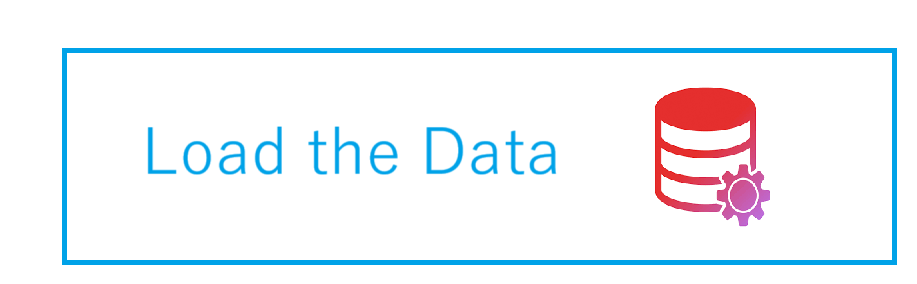

In [2]:
df=pd.read_csv("/kaggle/input/mba-admission-dataset/MBA.csv")

In [3]:
df.head()

,application_id,gender,international,gpa,major,race,gmat,work_exp,work_industry,admission
0,1,Female,False,3.30,Business,Asian,620.0,3.0,Financial Services,Admit
1,2,Male,False,3.28,Humanities,Black,680.0,5.0,Investment Management,NaN
2,3,Female,True,3.30,Business,NaN,710.0,5.0,Technology,Admit
3,4,Male,False,3.47,STEM,Black,690.0,6.0,Technology,NaN
4,5,Male,False,3.35,STEM,Hispanic,590.0,5.0,Consulting,NaN


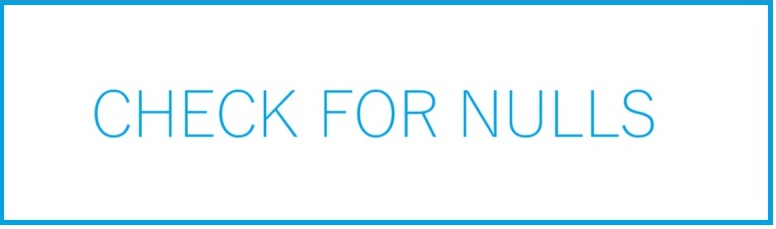

### WE WILL REPLACE NULL VALUES IN ADMISSION COLUMN TO "DENY" AND "OTHER" IN RACE COLUMN

In [4]:
df['admission'].fillna("Deny",inplace=True)
df['race'].fillna("Other",inplace=True)

/tmp/ipykernel_17/1475533936.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['admission'].fillna("Deny",inplace=True)
/tmp/ipykernel_17/1475533936.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df

In this notebook, we will draw out the conclusions based on the data provided. We'll find patterns in the profile of the applicants based on which we will predict whether they will be accepted for the course, or denied. 

Let's begin with our first step:

### Checking Data Sanity

In [5]:
df.isnull().sum()

application_id    0
gender            0
international     0
gpa               0
major             0
race              0
gmat              0
work_exp          0
work_industry     0
admission         0
dtype: int64

In [6]:
df

,application_id,gender,international,gpa,major,race,gmat,work_exp,work_industry,admission
0,1,Female,False,3.30,Business,Asian,620.0,3.0,Financial Services,Admit
1,2,Male,False,3.28,Humanities,Black,680.0,5.0,Investment Management,Deny
2,3,Female,True,3.30,Business,Other,710.0,5.0,Technology,Admit
3,4,Male,False,3.47,STEM,Black,690.0,6.0,Technology,Deny
4,5,Male,False,3.35,STEM,Hispanic,590.0,5.0,Consulting,Deny
...,...,...,...,...,...,...,...,...,...,...
6189,6190,Male,False,3.49,Business,White,640.0,5.0,Other,Deny
6190,6191,Male,False,3.18,STEM,Black,670.0,4.0,Consulting,Deny
6191,6192,Female,True,3.22,Business,Other,680.0,5.0,Health Care,Admit
6192,6193,Male,True,3.36,Business,Other,590.0,5.0,Other,Deny


### We will also drop the Application ID column because that is totally discreet and will not help the model in anyway.

In [7]:
df.drop(columns=['application_id'],inplace=True)

In [8]:
df.dtypes

gender            object
international       bool
gpa              float64
major             object
race              object
gmat             float64
work_exp         float64
work_industry     object
admission         object
dtype: object

In [9]:
categorical = list(df.select_dtypes(include=['object','bool']).columns)
numerical = list(df.select_dtypes(include=['float64']).columns)

In [10]:
print("Categorical Columns ",categorical)

print("Numerical Columns ",numerical)

Categorical Columns  ['gender', 'international', 'major', 'race', 'work_industry', 'admission']
Numerical Columns  ['gpa', 'gmat', 'work_exp']


In [11]:
# We will remove our dependent variable admission from our categorical columns, because we will use label encoder for it
categorical.remove("admission")

In [12]:
categorical

['gender', 'international', 'major', 'race', 'work_industry']

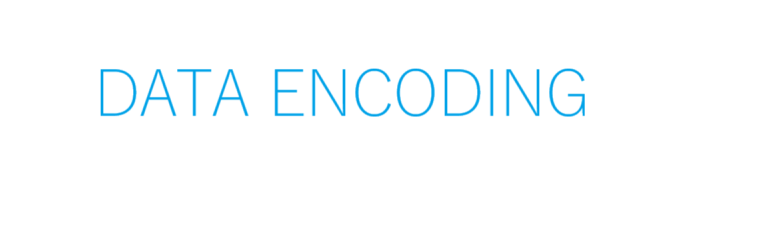

## Standardise the Numerical Values and Encode the Categorical Values

In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
transformer = ColumnTransformer(
[
    ("cat",OneHotEncoder(),categorical),
    ("numerical",StandardScaler(),numerical)
    
])

### Before we transform the column, let us first split the data into train and test . 

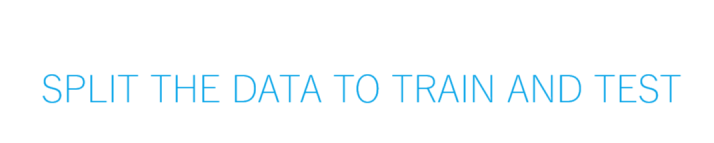

In [14]:
from sklearn.model_selection import train_test_split
X = df.drop(columns=['admission'])
Y = df['admission']
X_train,X_test,Y_train,Y_test= train_test_split(X,Y,test_size=0.25,random_state=42)


In [15]:
X_train_transformed = transformer.fit_transform(X_train)
X_test_transformed = transformer.transform(X_test)

In [16]:
from sklearn.preprocessing import LabelEncoder 
lbl  = LabelEncoder()
y_train_transformed = lbl.fit_transform(Y_train)
y_test_transformed  = lbl.transform(Y_test)

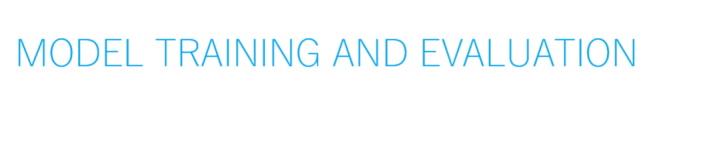

In [17]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_transformed,y_train_transformed)

RandomForestClassifier(random_state=42)

In [18]:
y_pred = rf.predict(X_test_transformed)

In [19]:
from sklearn.metrics import accuracy_score,classification_report
accuracy_score(y_test_transformed,y_pred)

0.8185926404131698

In [20]:
print(classification_report(y_pred,y_test_transformed))

              precision    recall  f1-score   support

           0       0.21      0.45      0.29       115
           1       0.95      0.85      0.90      1433
           2       0.00      0.00      0.00         1

    accuracy                           0.82      1549
   macro avg       0.39      0.43      0.40      1549
weighted avg       0.90      0.82      0.85      1549



In [21]:
import xgboost as xgb


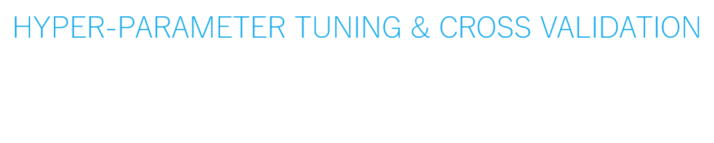

In [22]:
xgc =xgb.XGBClassifier(n_estimators=7,enable_categorical=True)

In [23]:
xgc.fit(X_train_transformed,y_train_transformed)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=7, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [24]:
y_pred = xgc.predict(X_test_transformed)

In [25]:
accuracy_score(y_pred,y_test_transformed)

0.8282763072950291

# FINAL ACCURACY = 82.82%
# BEST MODEL(AS PER MY CODE ABOVE) = XGBoost CLASSIFIER